In [1]:
#import libraries
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import *
import scipy as sp
from astropy.io import fits
import urllib as url
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import os
from matplotlib.ticker import MultipleLocator
import urllib.request
from array import *

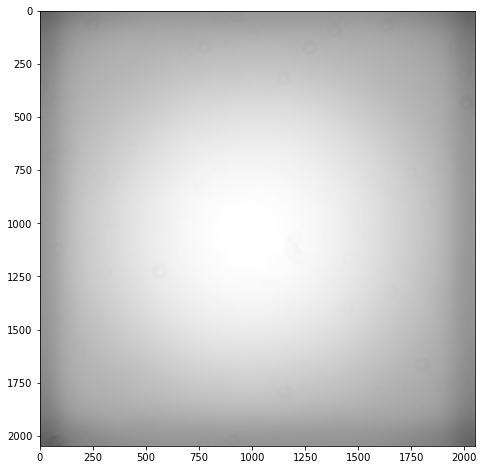

In [2]:
#open and disply the flat field data
combflat = fits.open('combflatr.fits')
header = combflat[0].header

data1 = combflat[0].data
data1.shape
plt.figure(figsize=(8, 8))
plt.imshow(data1.squeeze(), vmax=np.percentile(data1, 99), cmap="gray")
plt.show()

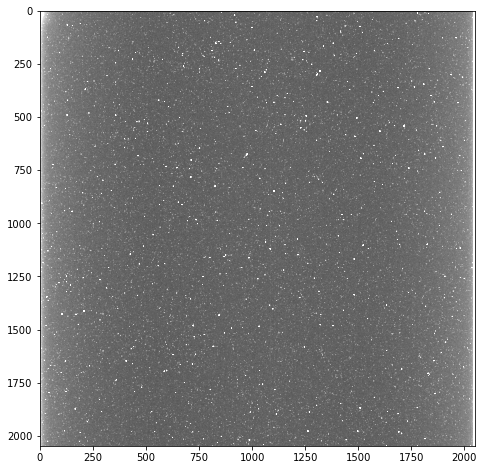

In [3]:
#open and display the dark field data
dark = fits.open('Dark-S001-R003-C003-B2.fts')
header = dark[0].header

data2 = dark[0].data
data2.shape
plt.figure(figsize=(8, 8))
plt.imshow(data2.squeeze(), vmax=np.percentile(data2, 99), cmap="gray")
plt.show()

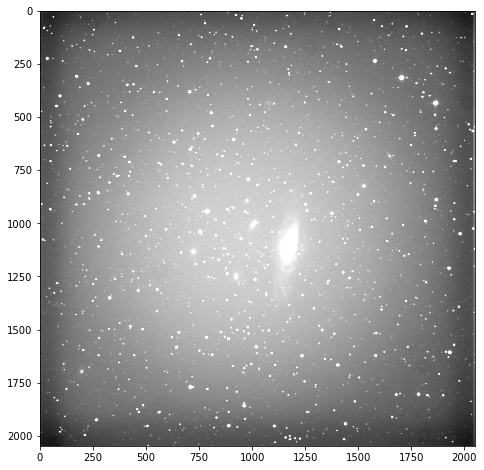

In [4]:
#open and display the raw NGC data

ngc = fits.open('NGC7331-S001-R001-C001-r.fts')
header = ngc[0].header

data3 = ngc[0].data
data3.shape
plt.figure(figsize=(8, 8))
plt.imshow(data3.squeeze(), vmax=np.percentile(data3, 99), cmap="gray")
plt.show()

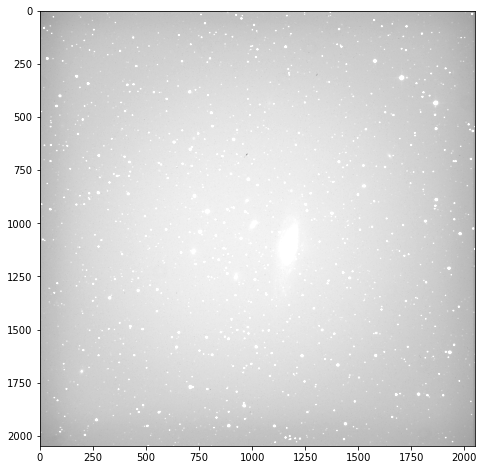

In [5]:
#Apply data corrections

dark_corrected_image = data3 - data1
flat_image = dark_corrected_image/data2

flat_image.shape
plt.figure(figsize=(8, 8))
plt.imshow(flat_image.squeeze(), vmax=np.percentile(flat_image, 99), cmap="gray")
plt.show()

In [6]:
ngc[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 2048 /fastest changing axis                           
NAXIS2  =                 2048 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2011-10-13T03:18:59' / [ISO 8601] UTC date/time of exposure start    
EXPTIME =   2.40000000000E+002 / [sec] Duration of exposure                     
EXPOSURE=   2.40000000000E+002 / [sec] Duration of exposure                     
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.022502500000002 /CCD temperature at start of exposure in C       
XPIXSZ  =   18.0000000000000

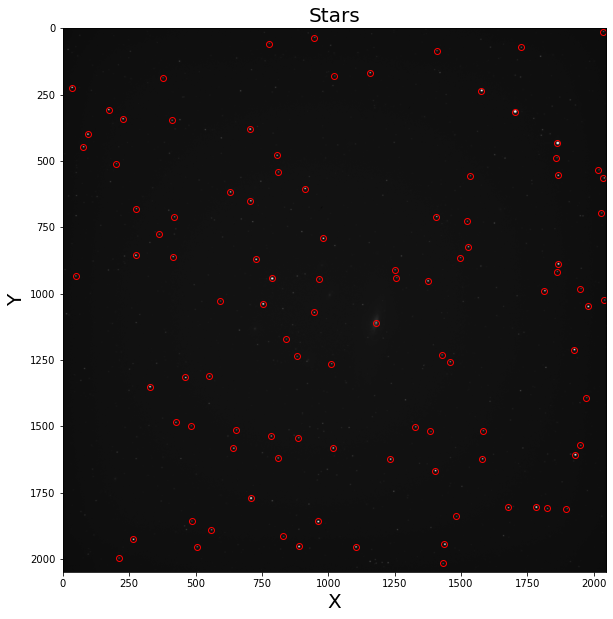

In [7]:
#function that finds centroid of image
def centroid(image):
    
    xvals = np.arange(image.shape[1])
    yvals = np.arange(image.shape[0])
    centroid_x = np.sum(xvals*image)/np.sum(image)
    centroid_y = np.sum(yvals*image.T)/np.sum(image)
    
    return np.array([centroid_y, centroid_x])

background = np.median(flat_image)

star_locations = []
BOX_SIZE = 10
im = flat_image.copy()

#find stars
for i in range(100):
    
    #find brightest pixel in the image
    brightest_pixel = np.array([np.where(im == np.max(im))[0][0], np.where(im == np.max(im))[1][0]])

    #create a "box" around that pixel
    box = im[brightest_pixel[0]-BOX_SIZE:brightest_pixel[0]+BOX_SIZE+1,
             brightest_pixel[1]-BOX_SIZE:brightest_pixel[1]+BOX_SIZE+1]
    box -= background
    
    #Get the centroid of that box
    c = centroid(box)
    
    #Map the centroid of the box back onto the orginal image
    c -= np.array([box.shape[1]//2,box.shape[0]//2])
    c += brightest_pixel
    
    star_locations.append(c)
    
    #Remove that star from the image so it isn't the brightest pixel anymore
    box[:,:] = background
    
#store and plot star locations    
star_locations = np.array(star_locations)

plt.figure(figsize=(10,10))
plt.plot(star_locations[:,1], star_locations[:,0], 'o', color = 'r', alpha = 1, fillstyle = "none")
plt.imshow(flat_image, cmap = 'gray')
plt.title("Stars", size = 20)
plt.xlabel("X", size = 20)
plt.ylabel("Y", size = 20)
plt.show()

Text(0, 0.5, 'y')

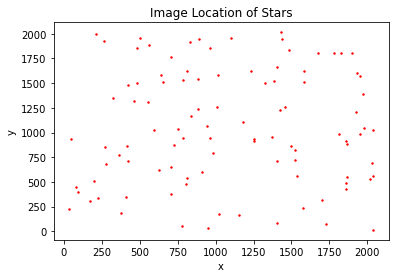

In [8]:
#plot star locations off of picture
plt.scatter(star_locations[:,1], star_locations[:,0], color='r', s =2)

plt.title("Image Location of Stars")
plt.xlabel("x")
plt.ylabel("y")

<ipython-input-9-8913fb3dfb1a>:45: RuntimeWarning: invalid value encountered in less
  w=np.where(rmag < 13.)[0]


(338.9, 339.7)

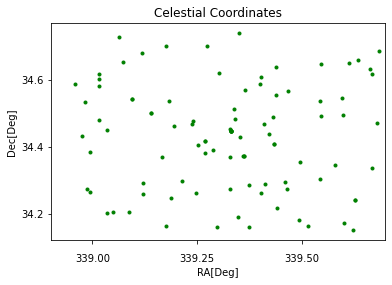

In [9]:
#Get the stars from the USNO catalog
def usno(radeg,decdeg,fovam):
    str1 = 'http://webviz.u-strasbg.fr/viz-bin/asu-tsv/?-source=USNO-B1'
    str2 = '&-c.ra={:4.6f}&-c.dec={:4.6f}&-c.bm={:4.7f}/{:4.7f}&-out.max=unlimited'.format(radeg,decdeg,fovam,fovam)
    sr = str1+str2 
    
    f = urllib.request.urlopen(sr) 
    s = f.read() 
    f.close()
    
    namecol, RAcol, DECcol, rband = 0, 1, 2, 12 
    null1, null2 ='     ',''
    
    s1 = s.splitlines() 
    s1 = s1[45:-1] # get rid of header 
    name = np.array([]) 
    rad = np.array([]) # RA in degrees 
    ded = np.array([]) # DEC in degrees 
    rmag = np.array([]) # rmage
    
    for k in s1: 
        kw = k.decode().split('\t')
        if kw[0] != '': 
            name = np.append(name,kw[namecol]) 
            rad = np.append(rad,float(kw[RAcol])) 
            ded = np.append(ded,float(kw[DECcol])) 
            # deal with case where no mag is reported 
            if (kw[rband] != null2) and (kw[rband] != null1):
                rmag = np.append(rmag, float(kw[rband]))
            else: 
                rmag = np.append(rmag,np.nan)
    
    return name,rad,ded,rmag

s1 = ngc
#readpositionfromtheFITSfileandconvertRA/DECtodegrees 
ras= s1[0].header['ra']
des = s1[0].header['dec']
radeg = 15*(float(ras[0:2])+float(ras[3:5])/60.+ float(ras[6:])/3600.)
dsgn = np.sign(float(des[0:3]))
dedeg= float(des[0:3])+dsgn*float(des[4:6])/60.+ dsgn*float(des[7:])/3600.
fovam=36.4 
type(fovam)
#sizeofsquaresearchfieldinarcmin 
name,rad,ded,rmag= usno(radeg,dedeg,fovam)
w=np.where(rmag < 13.)[0]
#selectonlybrightstarsr<15mag. 
plt.plot(rad[w],ded[w],'g.')
plt.locator_params(axis='x',nbins=4)
plt.locator_params(axis='y',nbins=4) 
plt.tick_params('x',pad=10) 
plt.xlabel('RA[Deg]') 
plt.ylabel('Dec[Deg]') 
plt.title("Celestial Coordinates")
plt.ticklabel_format(useOffset=False) 
#plt.axis('scaled')
plt.xlim([338.9,339.7])

In [10]:
#function that converts from celestial coordinates to standard coordinates
def standardcoords(rad, dec, a0, d0):
    ra = rad*np.pi/180
    dc = dec*np.pi/180
    
    a0 = a0*np.pi/180
    d0 = d0*np.pi/180
    
    cos_ra = np.cos(ra)
    sin_ra = np.sin(ra)
    cos_dc = np.cos(dc)
    sin_dc = np.sin(dc)
    
    X = -(cos_dc*np.sin(ra - a0))/(np.cos(d0)*cos_dc*(np.cos(ra - a0))+(sin_dc*np.sin(d0)))
    Y = -(np.sin(d0)*cos_dc*np.cos(ra-a0)-((np.cos(d0)*sin_dc)))/(np.cos(d0)*cos_dc*np.cos(ra-a0)+(sin_dc*np.sin(d0)))
    
    return X, Y

X, Y = standardcoords(rad[w],ded[w], radeg, dedeg)
                                                           

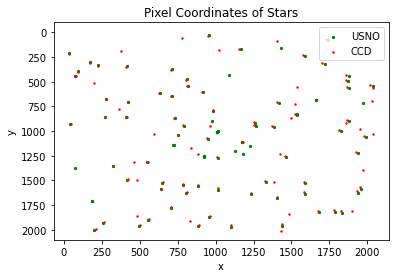

In [11]:
#convert from standard to pixel coordinates

f = 3454
p = 0.009*2
x0 = 1024
y0 = 1024
theta = np.pi

x=((f/p)*(X*np.cos(theta)-Y*np.sin(theta)))+x0
y = ((f/p)*(X*np.sin(theta)+Y*np.cos(theta)))+y0

x_new = list(map(lambda xi: 2048-xi, x))
x_new = np.array(x_new)

#plot the raw data over the usno data
plt.scatter(x_new,y, s = 5, color = "green", label = "USNO")
plt.title("Pixel Coordinates of Stars")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(2100, -100)

plt.scatter(star_locations[:,1], star_locations[:,0], color='r', s =2, label = "CCD")
plt.legend(loc="best")

In [49]:
#define the affine transformation function to solve for the proper positions of the stars
def leastsquares(X,Y, data):
    B = []
    ax = []
    ay = []
    
    for i in range(X.size):
        B.append([(f/p)*X[i], (f/p)*Y[i], 1])
        ax.append(data[0][i])
        ay.append(data[1][i])
        
    B = np.array(B)
    ax = np.array(ax)
    ay = np.array(ay)
    
    Bt = B.T
    Binv = np.linalg.inv(np.dot(Bt,B))
    
    c_x = np.dot(Binv,np.dot(Bt, ax))
    c_y = np.dot(Binv,np.dot(Bt, ay))
    
    a_11 = c_x[0]
    a_12 = c_x[1]
    x_0 = c_x[2]
    
    a_21 = c_y[0]
    a_22 = c_y[1]
    y_0 = c_y[2]
    
    chisq_x = np.dot((ax-np.dot(B, c_x)).T, (ax-np.dot(B, c_x)))
    chisq_y = np.dot((ay-np.dot(B, c_y)).T, (ay-np.dot(B, c_y)))
    
    redchi_x = chisq_x/(ax.size-3)
    redchi_y = chisq_y/(ay.size-3)
    
    constants = np.array([a_11, a_12, x_0, a_21, a_22, y_0, redchi_x, redchi_y])
    
    return constants

Text(0.5, 1.0, 'Corrected Pixel Coordinates')

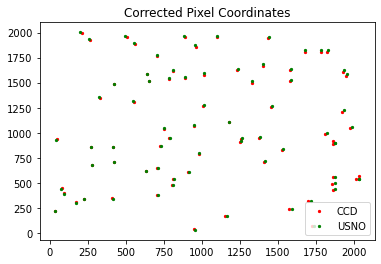

In [66]:
#define a function that removes outlier stars
def stars(x1,y1,x2,y2,threshold):
    x1new=[]
    y1new=[]
    x2new=[]
    y2new=[]
    
    for i in range (x1.size):
        for j in range (x2.size):
            if (abs(x1[i]-x2[j])<threshold) and (abs(y1[i]-y2[j])<threshold):
                x1new.append(x1[i])
                x2new.append(x2[j])
                y1new.append(y1[i])
                y2new.append(y2[j])
               
                break
                
        return np.array([x1new, x2new, y1new, y2new])

new_stars = stars(star_locations[:,1],star_locations[:,0],x_new, y, 25)
         
x_ccd = new_stars[0]
y_ccd = new_stars[2]
x_usno = new_stars[1]
y_usno = new_stars[3]

#plot the raw data over the usno data with outliers removed
plt.scatter(x_ccd, y_ccd, color='r', s =5, label = "CCD")
plt.scatter(x_usno,y_usno, s = 5, color = "green", label = "USNO")
plt.legend(loc="best")
plt.title("Corrected Pixel Coordinates")

In [69]:
#function converts to pixel coords from standard coords
def pixel(x,y):
    p = 0.018
    f = 3454
    X = np.array(x-1024)*(p/f)
    Y = np.array(y-1024)*(p/f)
    return(X,Y)
    
#find plate constants
pixelxy = pixel(x_usno, y_usno)

new_data = []
new_data.append(x_ccd)
new_data.append(y_ccd)

plates = leastsquares(pixelxy[0], pixelxy[1], new_data)
plates

array([ 9.90968666e-01,  6.26058014e-03,  1.01997310e+03, -4.66607055e-03,
        9.89248758e-01,  1.01942775e+03,  6.18704091e+00,  2.39578252e+01])

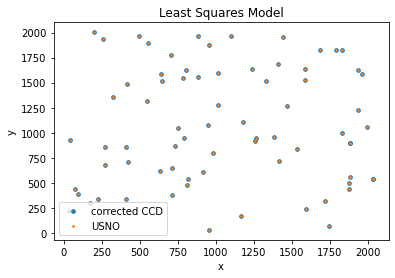

In [70]:
#use curve fit to find the correct star locations
def model_function(x,a,b,c):
    return (a*x + b*x + c)

p_optx, p_covx = curve_fit(model_function, pixelxy[0], x_usno, p0 = [0,0,1500])
p_opty, p_covy = curve_fit(model_function, pixelxy[1], y_usno, p0 = [0,0,1500])

xs = model_function(pixelxy[0], p_optx[0], p_optx[1], p_optx[2])
ys = model_function(pixelxy[1], p_opty[0], p_opty[1], p_opty[2])

xs_new = list(map(lambda xi: 2048-xi, xs))
xs_new = np.array(xs_new)

#plot corrected star locations over usno data
plt.scatter(xs,ys, s = 13, label = "corrected CCD")
plt.scatter(x_usno, y_usno, s = 3, label = "USNO")
plt.title("Least Squares Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="best")